# Introduction to simple GPR modelling using gprMax

In order to __"run"__ the Jupyter Notebook's code cells once you clicked on them just press __"Shift+Enter"__

You can download gprMax from www.gprmax.com and install it on your computer but you do not have to do this for this course. Experimenting with simple GPR models can be done with the Jupyter Notebooks without needing to do too much - hopefully none! - of difficult programming steps. 

A lot of information and documentation exist on the gprMax website and if you want to explore further you can get in touch via the discussion board or chat message or email. 

Please __do consult the extensive documentation__ for more details.

Download and install gprMax on Noteable. __This step needs to be performed only once__. 
Once created, Noteable will not delete the gprMax folder.

The easiest way to do this is to open a terminal window and type the following commands one at a time pressing enter after each of them.
```
git clone https://github.com/gprMax/gprMax.git ~/gprMax
cd ~/gprMax
python setup.py build 
python setup.py install 
```


First we always execute the following cell to setup things. It might take a while and you will see a star in the brackets that means it is running ...

In [49]:
run ../setup/preamble.ipynb

gprMax has been added to session!


Let us consider a simple 2D model of a single 20 mm metalic rebar placed in a half space material 9 cm from the surface. We assume that $z$-direction is infinite long and in the model it only has one cell width. So, we will consider an $x-y$ model of 0.24 metres by 0.21 metres using a source that has a centre frequency of 1500 MHz and a current waveform of a "ricker" wavelet. The half space material will be very simple with $\epsilon_r$ = 6 emulating concrete without any conductive losses. 

We initially setup the source and receiver at the centre of the model over the half space and we also will assume that there are no boundaries to this model for our waves and so absorbing boundaries are used by default around the edges of our numerical grid.


### Geometry of a metal cylinder buried in a dielectric half-space
<img style="float: left" src="cylinder_half_space_geo.png" width="50%" height="50%" />

The geometry of the scenario is straightforward - the transparent area around the boundary of the domain represents the PML region. The red cell is the source and the blue cell is the receiver.

For this initial example a detailed description of what each command in the input file does and why each command was used is given. The following steps explain the process of building the input file:

### 1. Determine the constitutive parameters for the materials

There will be three different materials in the model representing air, the dielectric half-space, and the metal cylinder. Air (free space) already exists as a built-in material in gprMax which can be accessed using the ``free_space`` identifier. The metal cylinder will be modelled as a Perfect Electric Conductor, which again exists as a built-in material in gprMax and can be accessed using the ``pec`` identifier. So the only material which has to be defined is for the dielectric half-space. It is a non-magnetic material, i.e. $\mu_r=1$ and $\sigma_*=0$ and with a relative permittivity of six, $\epsilon_r=6$, and zero conductivity, $\sigma=0$. The identifier ``half_space`` will be used.

    #material: 6 0 1 0 half_space

### 2. Determine the source type and excitation frequency

These should generally be known, often based on the GPR system or scenario being modelled. Low frequencies are used where significant penetration depth is important, whereas high frequencies are used where less penetration and better resolution are required. In this case a theoretical Hertzian dipole source fed with a Ricker waveform with a centre frequency of $f_c=1.5~\textrm{GHz}$ will be used to simulate the GPR antenna (see the bowtie antenna example model for how to include a model of the actual GPR antenna in the simulation).

    #waveform: ricker 1 1.5e9 my_ricker
    #hertzian_dipole: z 0.100 0.172 0 my_ricker

The Ricker waveform is created with the ``#waveform`` command, specifying an amplitude of one, centre frequency of 1.5 GHz and picking an arbitrary identifier of ``my_ricker``. The Hertzian dipole source is created using the ``#hertzian_dipole`` command, specifying a z direction polarisation (perpendicular to the survey direction if a B-scan were being created), location on the surface of the slab (one cell above the interface in this case), and using the Ricker waveform already created. We also specify at least one receiver using the ``#rx:`` command

    #rx: 0.140 0.172 0

### 3. Calculate a spatial resolution and domain size

In the guidance section it was stated that a good *rule-of-thumb* was that the spatial resolution should be one tenth of the smallest wavelength present in the model. To determine the smallest wavelength, the highest frequency and lowest velocity present in the model are required. The highest frequency is not the centre frequency of the Ricker waveform!  

You can use the following function to plot builtin waveforms and their FFTs.

Waveform characteristics...
Type: ricker
Maximum (absolute) amplitude: 0.999999
Centre frequency: 1.5e+09 Hz
Time to centre of pulse: 9.42809e-10 s
Time window: 1e-08 s (7501 iterations)
Time step: 1.33333e-12 s


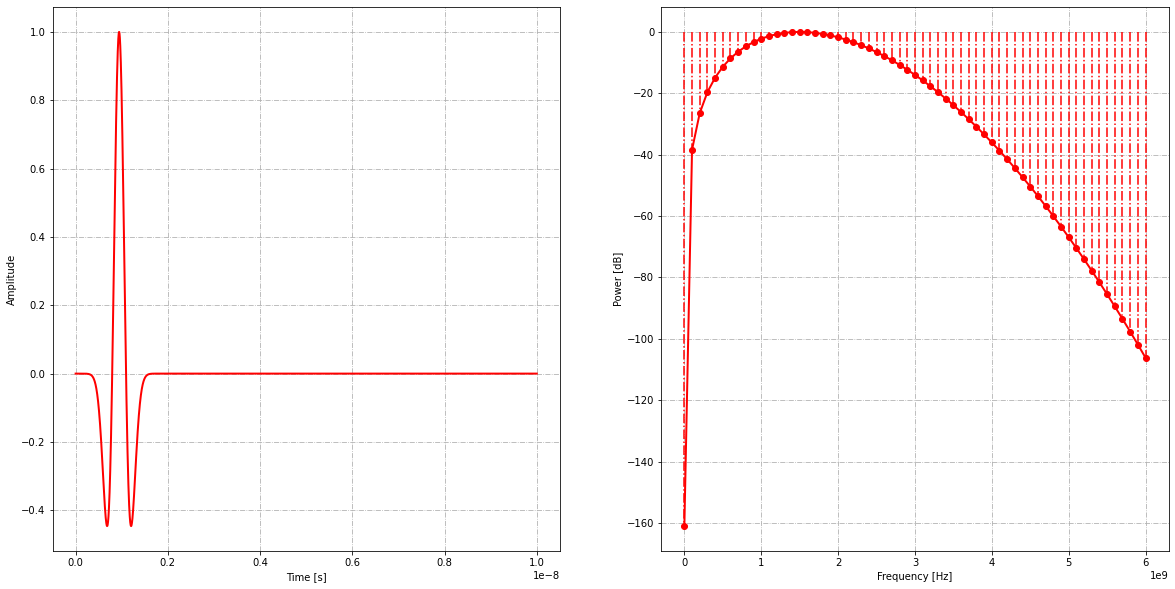

In [24]:
# view source function and its frequency spectrum 
# plot_source(type, amplitude, centre_frequency)

plot_source('ricker',1.0,1.5e9)

By examining the spectrum of a Ricker waveform it is evident much higher frequencies are present, i.e. at a level -40dB from the centre frequency, frequencies 2-3 times as high are present. In this case the highest significant frequency present in the model is likely to be around 4 GHz. To calculate the wavelength at 4 GHz in the half-space (which has the lowest velocity) use:

$$\lambda = \frac{c}{f \sqrt{\epsilon_r}}$$

In [25]:
from math import sqrt

# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 6

# Maximum frequency present in model
fmax = 4e9

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution
dmin = wmin / 10

print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))

Minimum wavelength: 0.0305974 m
Maximum spatial resolution: 0.00305974 m


This would give a minimum spatial resolution of 3 mm. However, the diameter of the cylinder is 20 mm so would be resolved to 7 cells. Therefore a better choice would be 2 mm which resolves the diameter of the rebar to 10 cells.

    #dx_dy_dz: 0.002 0.002 0.002

The domain size should be enough to enclose the volume of interest, plus allow 10 cells (if using the default value) for the PML absorbing boundary conditions and approximately another 10 cells of between the PML and any objects of interest. In this case the plan is to take a B-scan of the scenario (in the next example) so the domain should be large enough to do that. Although this is a 2D model one cell must be specified in the infinite direction (in this case the z direction) of the domain.

    #domain: 0.240 0.210 0.002

### 4. Choose a time window

It is desired to see the reflection from the cylinder, therefore the time window must be long enough to allow the electromagnetic waves to propagate from the source through the half-space to the cylinder and be reflected back to the receiver.

In [26]:
d = 0.090
t = (2 * d) / (c / sqrt(6))
print('Minimum time window: {:g} s'.format(t))

Minimum time window: 1.47071e-09 s


This is the minimum time required, but the source waveform has a width of 1.2 ns, to allow for the entire source waveform to be reflected back to the receiver an initial time window of 3 ns will be tested.

    #time_window: 3e-9

The time step required for the model is automatically calculated using the CFL condition (for this case in 2D).

### 5. Create the objects

Now physical objects can be created for the half-space and the cylinder. First the ``#box`` command will be used to create the half-space and then the ``#cylinder`` command will be given which will overwrite the properties of the half-space with those of the cylinder at the location of the cylinder.

    #box: 0 0 0 0.240 0.170 0.002 half_space
    #cylinder: 0.120 0.080 0 0.120 0.080 0.002 0.010 pec

## Put all the commands in an input file

There are many ways to put the commands that describe the model in an input file! The simplest here is to use:

In [61]:
%%writefile cylinder_Ascan_2D.in
#title: A-scan from a metal cylinder buried in a dielectric half-space
#domain: 0.240 0.210 0.002
#dx_dy_dz: 0.002 0.002 0.002
#time_window: 3e-9
#num_threads: 1

#material: 6 0 1 0 half_space

#waveform: ricker 1 1.5e9 my_ricker
#hertzian_dipole: z 0.100 0.172 0 my_ricker
#rx: 0.140 0.172 0

#box: 0 0 0 0.240 0.170 0.002 half_space
#cylinder: 0.120 0.080 0 0.120 0.080 0.002 0.010 pec

#geometry_view: 0 0 0 0.240 0.210 0.002 0.002 0.002 0.002 cylinder_half_space n

Overwriting cylinder_Ascan_2D.in


(we also included the ``#num_threads: 1`` command to make the execution faster on Noteable but do not use it otherwise)

In [ ]:
# View input file for gprMax

view_file('cylinder_Ascan_2D.in')

#title: A-scan from a metal cylinder buried in a dielectric half-space
#domain: 0.240 0.210 0.002
#dx_dy_dz: 0.002 0.002 0.002
#time_window: 3e-9

#material: 6 0 1 0 half_space

#waveform: ricker 1 1.5e9 my_ricker
#hertzian_dipole: z 0.100 0.170 0 my_ricker
#rx: 0.140 0.170 0

#box: 0 0 0 0.240 0.170 0.002 half_space
#cylinder: 0.120 0.080 0 0.120 0.080 0.002 0.010 pec

#geometry_view: 0 0 0 0.240 0.210 0.002 0.002 0.002 0.002 cylinder_half_space n



## Run the model

You can now run the model using:
    
    python -m gprMax cylinder_Ascan_2D.in

**Tip**: You can use the ``--geometry-only`` command line argument to build a model and produce any geometry views but not run the simulation. This option is useful for checking the geometry of the model is correct.

In [62]:
!python -m gprMax cylinder_Ascan_2D.in


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method 

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.6 (Big Smoke)

 Copyright (C) 2015-2022: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the
  terms of the GNU General Public License as published by the Free Software
  Foundation, either version 3 of the License, or (at your option) any later
  version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
  A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License along with
  gpr

## View the results

### Plot the A-scan

Once we have run our model let us see the output! We want to see the first output point and the Ez component which is the same direction as our source. The following function will give us the modelled GPR trace, a time vector useful for plotting and the position in model space of this output point

In [63]:
# Get output A-scan data
# dataVector, time, receiverPosition = gprMax_Ascan(filename, rx, rxcomponent)

Ascan, time, pos = gprMax_Ascan('cylinder_Ascan_2D.out', 1, 'Ez')

Then we are ready to plot the result!!! 

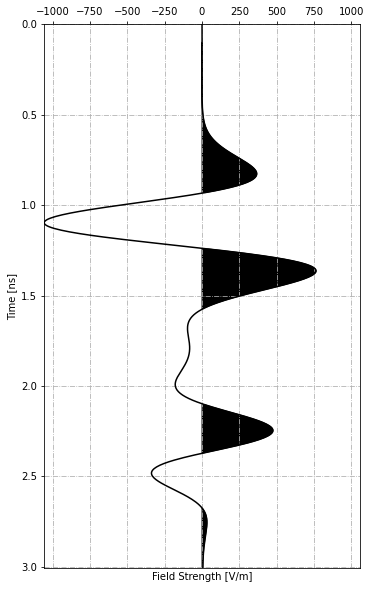

In [64]:
# Plot A-scan - plot_Ascan(trace, time_vector, rotate)

plot_Ascan(Ascan, time, rotate = False)

We can also see the geometry of our model to make sure it looks OK! Remember the extension of a geometry file produced by gprMax is __.vti__

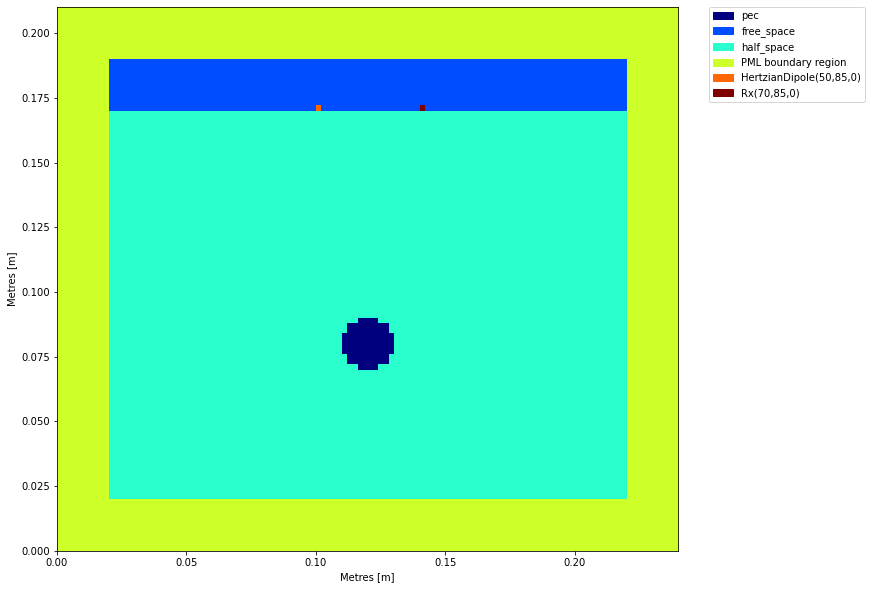

In [57]:
# View the 2D gprMax model to see if it is OK

gprMax_model('cylinder_half_space.vti')

## What happens if we change the properties of the cylindrical target?